In [28]:
using CommonDataFormat
using Dates
using Statistics

In [33]:
omni_file = joinpath(pwd(), "../Data/MAVEN/mvn_swe_l2_arc3d_20210824_v05_r01.cdf")
ds = CDFDataset(omni_file)

CDFDataset{CommonDataFormat.GzipCompression, Int64}
path: /Users/admin/Documents/WorkSpace/JuliaCode/Tianwen/src/../Data/MAVEN/mvn_swe_l2_arc3d_20210824_v05_r01.cdf
variables:
  epoch : (10800,) support_data CDF_TIME_TT2000 [2021-08-24T00:00:06.106 … 2021-08-24T23:59:57.421]
  time_met : (10800,) support_data CDF_DOUBLE [6.830350205842682e8 … 6.831214118236176e8]
  time_unix : (10800,) support_data CDF_DOUBLE [1.6297632061057315e9 … 1.6298495974213247e9]
  binning : (10800,) support_data CDF_UINT1 [2 … 1]
  counts : (6, 16, 64, 10800) support_data CDF_FLOAT [NaN … 36.502815]
  diff_en_fluxes : (6, 16, 64, 10800) data CDF_FLOAT [NaN … 7.956308e7]
  variance : (6, 16, 64, 10800) data CDF_FLOAT [0.0 … 1.7462033e14]
  secondary : (6, 16, 64, 10800) data CDF_FLOAT [NaN … 3.184421e6]
  geom_factor : (1,) support_data CDF_FLOAT [0.0001244383 … 0.0001244383]
  g_engy : (64, 1) support_data CDF_FLOAT [0.896666 … 0.5554217]
  de_over_e : (64, 1) support_data CDF_FLOAT [0.10999333 … 0.12358713]
 

In [39]:
epoch = ds["epoch"][:]
energy = ds["energy"][:]
#flux_3d = ds["counts"][:,:,:,:]

64-element Vector{Float32}:
 4627.5
 4118.506
 3665.4976
 3262.3171
 2903.484
 2584.12
 2299.884
 2046.9121
 1821.7654
 1621.3833
 1443.0419
 1284.3169
 1143.0505
    ⋮
   10.809248
    9.620303
    8.562134
    7.6203556
    6.7821674
    6.036174
    5.372235
    4.781325
    4.2554107
    3.787344
    3.3707614
    3.0

In [41]:
using CairoMakie
using LinearAlgebra
using Interpolations

target_time_str = "2021-08-24T07:30:00"
# 将目标时间字符串解析为 DateTime 对象
target_dt = DateTime(target_time_str, dateformat"yyyy-mm-ddTHH:MM:SS")

epoch = ds["epoch"][:]
energy = ds["energy"][:]
flux_4d = ds["diff_en_fluxes"][:, :, :, :]
times_dates = DateTime.(epoch)
time_val, time_idx = findmin(d -> abs(d - target_dt), times_dates)

output_file = joinpath(pwd(), "../Picture/MAVEN/MAVEN_e_spectrum$(epoch[time_idx]).png")

# 选择一个探测器（这里选择第一个探测器，dindex=0）
detector_idx = 1  # 对应第一个探测器
# 提取该时间点、该探测器的数据
# 注意：flux_4d 形状为 (6, 16, 64, 10800)
# 我们取第一个探测器，所有方位角，所有能量通道，指定时间点
flux_3d = flux_4d[detector_idx, :, :, time_idx]  # 形状: (16 角度索引, 64 能量通道)

# 扫描角度：根据图中标注，扫描角度为 0° 到 360°
# CDF 中没有直接给出扫描角度数组，但可以从角度索引 0-15 对应 0-360° 均匀分布
num_angles = size(flux_3d, 1)  # 16
scan_angle = LinRange(0, 360, num_angles)  # 0° 到 360°

# 选择要绘制的能量值（对应图中标注的能量：4, 10, 20, 35, 57, 92, 144, 222 eV）
target_energies = [4, 10, 20, 35, 57, 92, 144, 222]

# 找到最接近目标能量的索引
energy_indices = [argmin(abs.(energy .- E)) for E in target_energies]

# 设置颜色循环
colors = [
    :blue, :green, :red, :cyan,
    :magenta, :orange, :brown, :purple
]

# 创建 CairoMakie 图形
fig = Figure(resolution=(800, 600))
ax = Axis(fig[1, 1],
    xlabel="SCAN ANGLE (deg)",
    ylabel="DIFFERENTIAL ENERGY FLUX\n(eV/[eV cm² sr s])",
    xticks=0:90:360,
    yscale=log10,
    title="ELECTRON DISTRIBUTION MODEL 2\nTime: $(epoch[time_idx])"
)

# 设置坐标轴限制
xlims!(ax, 0, 360)

# 对每个目标能量绘制曲线
for (i, (E, idx, col)) in enumerate(zip(target_energies, energy_indices, colors))
    flux_at_E = flux_2d[:, idx]  # 在当前能量下，随扫描角度的通量
    # 处理无效值（如填充值 -1e31）
    valid = flux_at_E .> 0
    if any(valid)
        lines!(ax, scan_angle[valid], flux_at_E[valid],
            color=col, linewidth=1.5,
            label="$(E) eV")
    end
end

# 添加图例
axislegend(ax, position=:rt, title="Energy (eV)", framevisible=false)

# 保存图像（可选）
save(output_file, fig)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264



=== 🔍 数据侦探报告 ===
变量: diff_en_fluxes
类型: Array{Float32, 3}
尺寸: (16, 64, 26926)
维度数: 3

✅ 数据已经是 3 维，无需修复。
修复后尺寸: (16, 64, 26926)

--- 开始处理与绘图 ---
绘图维度: X=26926, Y=64, Z=(64, 26926)


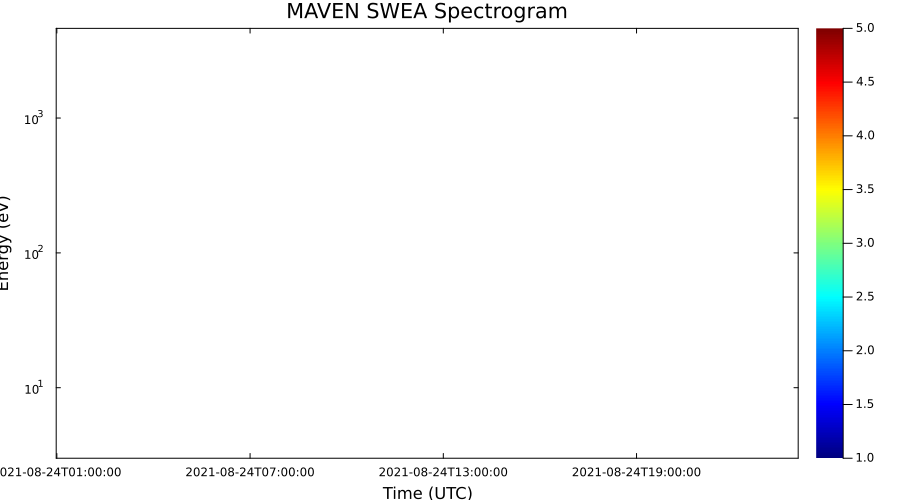

y points not sorted in ascending order
y points not sorted in ascending order
y points not sorted in ascending order


In [44]:
times = ds["epoch"][:]
# 简化的时间转换 (视具体 CDF 库版本可能需要调整)
# TT2000 0点大约是 2000-01-01T12:00:00，但在 Julia 中通常作为绘图索引即可

# 读取能量 (Y轴)
# 这是一个 1D 数组，长度 64
energy = ds["energy"][:]

# 读取通量数据 (Z轴/颜色)
# 维度通常是: [PitchAngle(16), Energy(64), Time(N)]
# 注意：Julia 是列主序 (Column-Major)，具体维度顺序取决于 CDF 库的实现，
# 但根据骨架文件描述，它是 Time 依赖的。
raw_flux = ds["diff_en_fluxes"][:, :, :]

println("\n=== 🔍 数据侦探报告 ===")
println("变量: diff_en_fluxes")
println("类型: ", typeof(raw_flux))
println("尺寸: ", size(raw_flux))
println("维度数: ", ndims(raw_flux))
println("========================\n")

# ========================================================
# 2. 万能维度修复 (Universal Reshape)
# ========================================================

flux_3d = nothing # 初始化

if ndims(raw_flux) == 3
    # 情况 A: 已经是标准的 3 维 (16 x 64 x N)
    println("✅ 数据已经是 3 维，无需修复。")
    global flux_3d = raw_flux

elseif ndims(raw_flux) == 1 && eltype(raw_flux) <: AbstractArray
    # 情况 B: 它是“矩阵的向量” (Vector of Matrices)
    # 例如: 26926-element Vector{Matrix{Float32}}
    println("⚠️ 检测到‘矩阵向量’，正在拼接为 3D 数组...")
    # 将 vector 沿着第 3 维拼接
    global flux_3d = cat(raw_flux..., dims=3)

elseif ndims(raw_flux) == 2
    # 情况 C: 它是“压扁”的 2 维矩阵 (1024 x N)
    # 骨架文件说是 16 (PA) x 64 (Energy)，也就是 1024
    if size(raw_flux, 1) == 16 * 64
        println("⚠️ 检测到‘压扁’的 2D 数据，正在重塑为 (16, 64, N)...")
        # 强制 Reshape
        global flux_3d = reshape(raw_flux, 16, 64, size(raw_flux, 2))
    else
        println("⚠️ 警告: 2D 数据行数不是 1024 (16*64)，而是 $(size(raw_flux, 1))。")
        println("尝试按 (64, 16, N) 重塑...")
        global flux_3d = reshape(raw_flux, 64, 16, size(raw_flux, 2))
        # 此时需要转置前两维以匹配 (PA, Energy)
        global flux_3d = permutedims(flux_3d, (2, 1, 3))
    end

else
    error("❌ 无法自动识别数据结构。请把上面的‘数据侦探报告’发给我。")
end

println("修复后尺寸: ", size(flux_3d))

# ========================================================
# 3. 标准处理与绘图 (逻辑同前)
# ========================================================

println("\n--- 开始处理与绘图 ---")

# 1. 强制转为 Julia 数组
final_data = Array(flux_3d)

# 2. 降维 (平均 PA 维度) -> [1, 64, N]
flux_mean = mean(final_data, dims=1) 

# 3. 降维 -> [64, N]
flux_2d = dropdims(flux_mean, dims=1)
z_matrix = Float64.(flux_2d)

# 4. 清洗
map!(x -> (x <= 0.0 || x < -1e30) ? NaN : x, z_matrix, z_matrix)
z_log = log10.(z_matrix)

# 5. 坐标
const J2000 = DateTime(2000, 1, 1, 12, 0, 0)
x_time = [J2000 + Nanosecond(t.instant) for t in times]
y_energy = Float64.(vec(energy))

# 6. 绘图
dim_check = size(z_log)
println("绘图维度: X=$(length(x_time)), Y=$(length(y_energy)), Z=$dim_check")

if dim_check == (length(y_energy), length(x_time))
    z_final = z_log
elseif dim_check == (length(x_time), length(y_energy))
    z_final = permutedims(z_log)
else
    # 最后的救命稻草：如果在 reshape 过程中搞反了 PA 和 Energy
    # 这里可能会出现维度不匹配 (16 vs 64)。
    # 我们只关心 Y 轴是 64。
    if dim_check[1] == 16 && length(y_energy) == 64
        println("⚠️ 发现维度可能是 (PA, Time)，数据似乎在 reshape 时丢失了 Energy 维？")
        error("重塑逻辑需要人工干预，请告诉我侦探报告的结果。")
    else
        error("维度严重不匹配。")
    end
end

heatmap(
    x_time,
    y_energy,
    z_final,
    yscale = :log10,
    ylim = (minimum(y_energy), maximum(y_energy)),
    color = :jet,
    clims = (1, 5),
    xlabel = "Time (UTC)",
    ylabel = "Energy (eV)",
    title = "MAVEN SWEA Spectrogram",
    framestyle = :box,
    grid = false,
    size = (900, 500)
)

In [ ]:
times = ds["epoch"][:]
fieldnames(typeof(times[1]))

In [57]:
ds["epoch"][:]

26926-element Vector{TT2000}:
 2021-08-24T00:57:40.078
 2021-08-24T00:57:42.078
 2021-08-24T00:57:44.078
 2021-08-24T00:57:46.078
 2021-08-24T00:57:48.078
 2021-08-24T00:57:50.078
 2021-08-24T00:57:52.078
 2021-08-24T00:57:54.078
 2021-08-24T00:57:56.078
 2021-08-24T00:57:58.078
 2021-08-24T00:58:00.078
 2021-08-24T00:58:02.078
 2021-08-24T00:58:04.077
 ⋮
 2021-08-24T23:59:37.421
 2021-08-24T23:59:39.421
 2021-08-24T23:59:41.421
 2021-08-24T23:59:43.421
 2021-08-24T23:59:45.421
 2021-08-24T23:59:47.421
 2021-08-24T23:59:49.421
 2021-08-24T23:59:51.421
 2021-08-24T23:59:53.421
 2021-08-24T23:59:55.421
 2021-08-24T23:59:57.421
 2021-08-24T23:59:59.421

In [43]:
ds["diff_en_fluxes"][:, :, :]

16×64×26926 Array{Float32, 3}:
[:, :, 1] =
 NaN    NaN    NaN    NaN    NaN    NaN    NaN    …  NaN          NaN
 NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN          NaN
 NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN          NaN
   0.0    0.0    0.0    0.0    0.0    0.0    0.0       3.66145f7    5.10245f7
   0.0    0.0    0.0    0.0    0.0    0.0    0.0       4.6327f7     7.07571f7
   0.0    0.0    0.0    0.0    0.0    0.0    0.0  …    7.00063f7    1.02697f8
   0.0    0.0    0.0    0.0    0.0    0.0    0.0       7.24895f7    3.92311f7
   0.0    0.0    0.0    0.0    0.0    0.0    0.0       7.95061f7    6.31518f7
   0.0    0.0    0.0    0.0    0.0    0.0    0.0       3.79254f7    3.77162f7
   0.0    0.0    0.0    0.0    0.0    0.0    0.0       3.31365f7    5.71987f7
   0.0    0.0    0.0    0.0    0.0    0.0    0.0  …    7.61884f7    7.11069f7
   0.0    0.0    0.0    0.0    0.0    0.0    0.0       1.61458f8    1.56238f8
   0.0    0.0    0.0    0.0    0.0    0.0    

In [41]:
ds["energy"][:]

64-element Vector{Float32}:
 4627.5
 4118.506
 3665.4976
 3262.3171
 2903.484
 2584.12
 2299.884
 2046.9121
 1821.7654
 1621.3833
 1443.0419
 1284.3169
 1143.0505
    ⋮
   10.809248
    9.620303
    8.562134
    7.6203556
    6.7821674
    6.036174
    5.372235
    4.781325
    4.2554107
    3.787344
    3.3707614
    3.0

In [ ]:
ds["pa"][:]